In [1]:
%reload_ext autoreload
%autoreload

%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})

# import helper functions
from src.utls import prep_raw_data

In [2]:
# (import) helper functions
dir_proj = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_proj.parent.absolute(), "data")
dir_prep = Path.joinpath(dir_proj.parent.absolute(),"results")
print(dir_rawdata)


c:\Users\User\Desktop\kiel\tremor_music_ap\data


In [3]:
# find all videos in path
f_list = os.listdir(dir_rawdata)
str_match = 'BS'
dir_patients = [s for s in f_list if str_match in s]

In [4]:
# define cfg vars
cfg_srate = 100
cfg_group = {1:"Standard & exp. music", 2:"Standard & unspecific music", 3: "Only Standard", 4: "Placebo"}
cfg_trial = {1: "Standing flexed", 2:"Sitting", 3: "Standing relaxed"}
cfg_visit = {1:"Inital", 2:"14-days"}


In [5]:
 # set params for epoch processing and plotting

cfg_filter_window = [2,12]
cfg_freqs_oi = [2,10]
cfg_thresh_level_mp = .5

# prelocate df
id = []
visit = []
task = []
axis = []
freq = []
pow = []

tmp_dir_patients = dir_patients
for dir_sub in tqdm(tmp_dir_patients):
    nms_files = os.listdir(Path.joinpath(dir_rawdata,dir_sub))

    for fnm in nms_files:
        tmp = pd.read_excel(Path.joinpath(dir_rawdata,dir_sub,fnm),header=None)

        # extract visit specific info
        tmp_id = dir_sub.strip()
        tmp_visit = fnm.split(' - ')[1]
        tmp_task = fnm.split('prova ')[1][0]
        #print(f"Processing visit {tmp_visit} from {tmp_id}")

        # process raw data
        x = tmp.iloc[:,0]
        y = tmp.iloc[:,1]
        z = tmp.iloc[:,2]

        x_zm, freq_x , spec_x = prep_raw_data(x, cfg_srate, 1, 15)
        y_zm, freq_y , spec_y = prep_raw_data(y, cfg_srate, 1, 15)
        z_zm, freq_z , spec_z = prep_raw_data(z, cfg_srate, 1, 15)

        # append data
        n_freqs = len(freq_x) * 3
        if not len(freq_x) == len(freq_y == len(freq_z)):
            raise ValueError("Frequency estimation has different binds for acc axis")
        
        id.extend( [tmp_id] * n_freqs)
        visit.extend( [tmp_visit] * n_freqs)
        task.extend( [tmp_task] * n_freqs)
        axis.extend(['x'] * (n_freqs//3))
        axis.extend(['y'] * (n_freqs//3))
        axis.extend(['z'] * (n_freqs//3))

        freq.extend(freq_x)
        freq.extend(freq_y)
        freq.extend(freq_z)

        pow.extend(spec_x)
        pow.extend(spec_y)
        pow.extend(spec_z)






100%|██████████| 42/42 [00:15<00:00,  2.69it/s]


In [6]:
single_sub = pd.DataFrame(list(zip(id,visit,task,axis,freq,pow)), columns=["id","visit","task","axis","frequency","power"])

In [7]:
single_sub.to_csv(Path.joinpath(dir_prep,"single_subj_pow.csv"), index=False)

<AxesSubplot:xlabel='frequency', ylabel='power'>

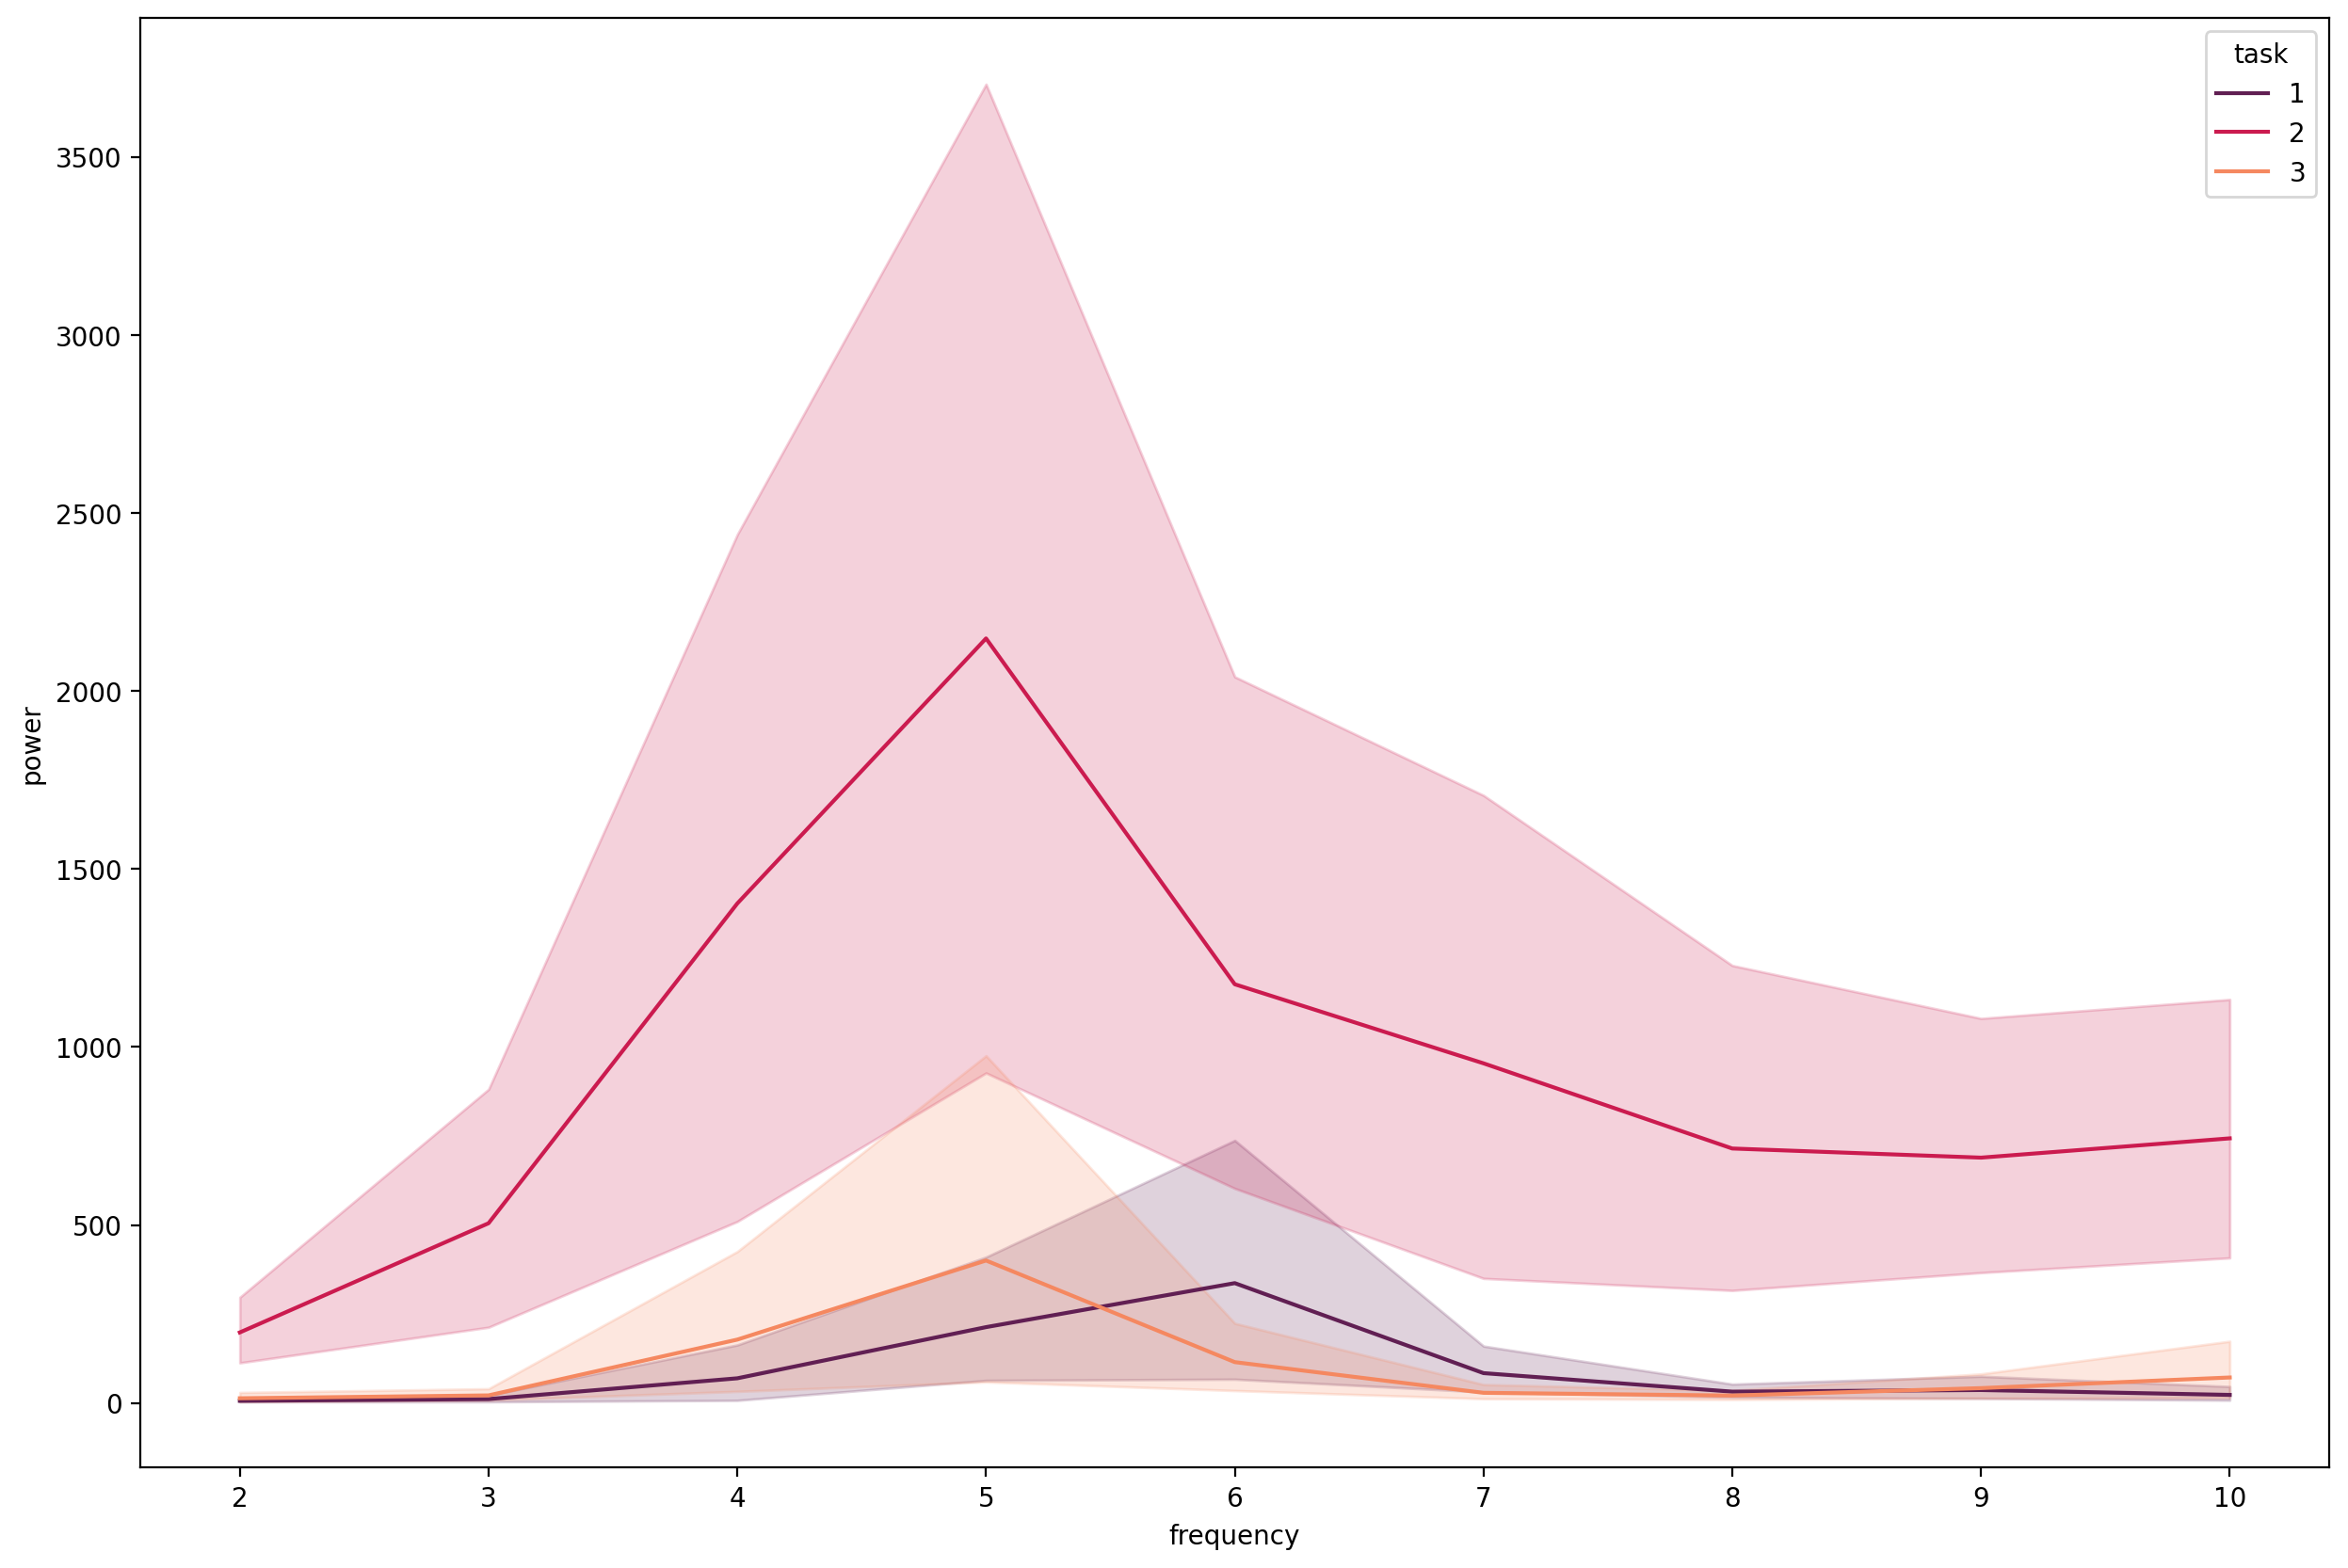

In [11]:
x_dat = single_sub.loc[single_sub["axis"] == "x",:]
sns.lineplot(data=x_dat,x="frequency",y="power",hue="task", palette="rocket")